# 🏥Healthcare Visits & Vouchers Analysis

This notebook analyzes a simulated healthcare dataset using **pandas**.

The data model includes:

- `patients`: one row per patient
- `clinic`: one row per clinic / hospital / office
- `medical_condition`: one row per condition type
- `visit`: one row per visit (billable event)
- `visit_condition`: bridge table linking visits ↔ conditions
- `voucher`: one row per voucher used to cover part of a visit balance

The business questions we will be answering:
1. Which clinics bring in the most revenue?
2. What are the most common medical conditions?
3. How much do insured vs uninsured patients owe?
4. Which patients have the largest outstanding balances?
5. How much voucher money is each clinic using?
6. Which visits had multiple conditions?
7. What does monthly revenue look like over time?
8. Which vouchers are about to expire?
9. Who are our repeat patients?
10. Are some clinic types more expensive than others?
11. How does utilization differ by each age band and gender?

In [2]:
import pandas as pd
from datetime import timedelta

pd.set_option("display.max_columns", 50)

patients = pd.read_csv("Patients_filled_utf_1.csv")
clinic = pd.read_csv("Clinic_filled_utf.csv")  # or "Hospital_filled_utf.csv"
visit = pd.read_csv("Visit_filled_utf.csv")
medical_condition = pd.read_csv("Medical_Condition_filled_utf.csv")
visit_condition = pd.read_csv("Visit_condition_filled_re_1.csv")
voucher = pd.read_csv("Voucher_filled_utf.csv")

date_cols_config = [
    (patients, ["dob"]),
    (visit, ["visit_date", "due_date"]),
    (voucher, ["voucher_date", "expiration_date"]),
]

for df, cols in date_cols_config:
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])


print("Patients:", patients.shape)
print("Clinic:  ", clinic.shape)
print("Visit:   ", visit.shape)
print("Visit_condition:", visit_condition.shape)
print("Medical_condition:", medical_condition.shape)
print("Voucher:", voucher.shape)

patients.head()


Patients: (300, 8)
Clinic:   (60, 6)
Visit:    (700, 8)
Visit_condition: (1156, 3)
Medical_condition: (98, 2)
Voucher: (700, 6)


,patient_id,first_name,last_name,dob,gender,insurance,phone,email
0,1,Chartruse,Jones,1993-07-28,Female,0,555-8359,chartruse.jones@healthcare.org
1,2,Randy,Monts,1997-02-12,Male,1,277-9829,randy.monts@healthcare.org
2,3,Jackson,Richardson,1985-05-16,Other,0,322-2395,jackson.richardson@healthcare.org
3,4,Bianca,Soto,1981-07-24,Female,1,892-5906,bianca.soto@healthcare.org
4,5,Brandon,Bose,2016-08-09,Male,0,234-4744,brandon.bose@healthcare.org


In [22]:
import matplotlib.pyplot as plt

PALETTE = [
    "#4C72B0",  # blue
    "#55A868",  # green
    "#C44E52",  # red
    "#8172B3",  # purple
    "#CCB974",  # mustard
    "#64B5CD",  # light blue
    "#4C9F70",  # teal
    "#D55E00",  # orange
    "#8C8C8C",  # gray
    "#F2B701",  # yellow
]

## Q1 – Which clinics bring in the most revenue?

**Business question:**  
How much total revenue has each clinic generated (based on the `total_bill`), and which clinics are the top earners?

**Behind the Scenes:**

1. Join `visit` with `clinic` on `clinic_id` (similar to a SQL JOIN).
2. Group by each clinic (`clinic_id`, `clinic_name`, `type`).
3. Aggregate:
   - `total_revenue` = sum of `total_bill`
   - `visit_count` = number of visits
4. Sort by `total_revenue` descending.

In [3]:
visit_clinic = visit.merge(clinic, on="clinic_id", how="left")

q1 = (
    visit_clinic
    .groupby(["clinic_id", "clinic_name", "type"], as_index=False)
    .agg(
        total_revenue=("total_bill", "sum"),
        visit_count=("visit_id", "count"),
    )
    .sort_values("total_revenue", ascending=False)
)

q1.head(10)

,clinic_id,clinic_name,type,total_revenue,visit_count
44,77075,Lakeside Surgery Center,Surgery Center,13219.24,17
59,97885,Day Surgery Center,Surgery Center,11413.15,15
9,16715,Pinecrest Hospital,Hospital,10745.73,20
0,10329,Pediatric Ward Hospital,Hospital,10726.89,18
22,43837,Outpatient Surgery Center,Surgery Center,10469.32,15
17,32173,Mercy Medical Center,Hospital,9459.72,16
39,68373,St. Mary's Hospital,Hospital,8892.14,16
23,46393,Eastside General Hospital,Hospital,8696.26,14
7,16387,Metro Hospital,Hospital,8105.77,15
30,54799,Heritage Medical Center,Hospital,7912.30,14


### Visualization – Top Clinics by Revenue

This bar chart shows the top clinics by total revenue, based on the `total_bill` from all visits.

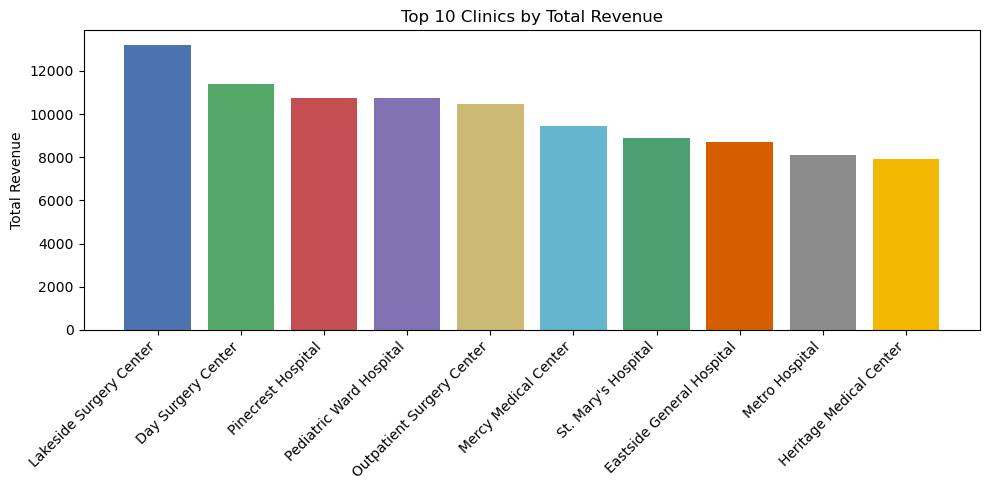

In [24]:
q1_top10 = q1.head(10)

plt.figure(figsize=(10, 5))
plt.bar(
    q1_top10["clinic_name"],
    q1_top10["total_revenue"],
    color=PALETTE[:len(q1_top10)]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title("Top 10 Clinics by Total Revenue")
plt.tight_layout()
plt.show()

## Q2 – What are the most common medical conditions?

**Business question:**  
Which conditions are we treating most often, and how many visits involve each one?

**Behind the Scenes:**

1. Each row of `visit_condition` = one (visit, condition) pair.
2. Join `visit_condition` with `medical_condition` on `condition_id`.
3. Group by `condition_id` + `condition_name`.
4. Count how many rows/visits each condition appears in.

In [4]:
vc_cond = visit_condition.merge(medical_condition, on="condition_id", how="left")

q2 = (
    vc_cond
    .groupby(["condition_id", "condition_name"], as_index=False)
    .agg(visit_count=("visit_id", "count"))
    .sort_values("visit_count", ascending=False)
)

q2.head(15)

,condition_id,condition_name,visit_count
56,57,Tonsillitis,20
17,18,Hypothyroidism,18
73,74,Meningitis,17
94,95,Preeclampsia,17
22,23,Hepatitis A,17
70,71,Botulism,16
36,37,Chronic Kidney Disease,16
24,25,Hepatitis C,16
88,89,Parkinson's,16
62,63,Dengue Fever,16


### Visualization – Most Common Conditions

This chart highlights the conditions that appear in the most visits.

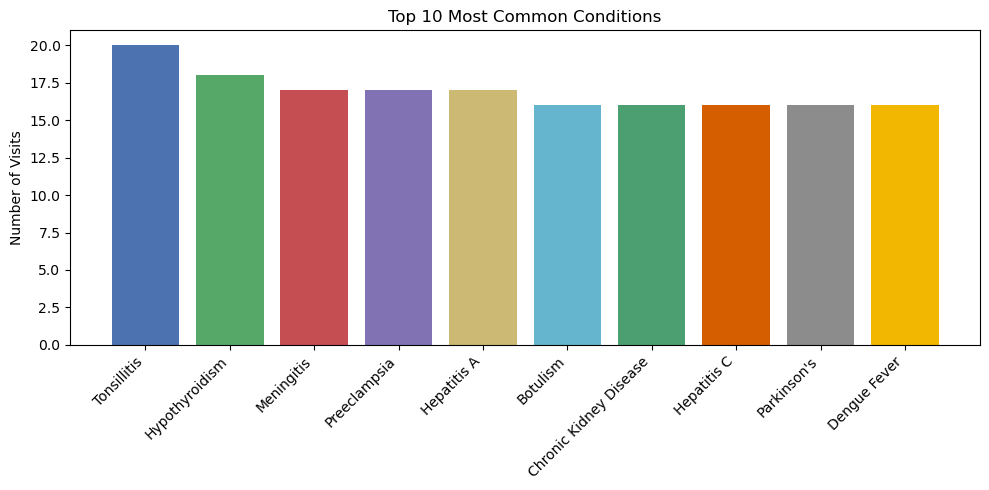

In [31]:
q2_top10 = q2.head(10)

plt.figure(figsize=(10, 5))
plt.bar(
    q2_top10["condition_name"],
    q2_top10["visit_count"],
    color=PALETTE[:len(q2_top10)]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Visits")
plt.title("Top 10 Most Common Conditions")
plt.tight_layout()
plt.show()

## Q3 – How much do insured vs uninsured patients owe?

**Business question:**  
On average and in total, how much `amount_due` remains for patients with insurance vs without insurance?

**Behind the Scenes:**

1. Join `visit` with `patients` on `patient_id`.
2. Map `insurance` (1/0) to labels: `"Insured"` / `"Uninsured"`.
3. Group by `insurance_status`.
4. Compute:
   - average unpaid amount
   - total unpaid amount
   - number of visits in each group.

In [5]:
visit_pat = visit.merge(patients, on="patient_id", how="left")

visit_pat["insurance_status"] = visit_pat["insurance"].map({1: "Insured", 0: "Uninsured"})

q3 = (
    visit_pat
    .groupby("insurance_status", as_index=False)
    .agg(
        avg_amount_due=("amount_due", "mean"),
        total_amount_due=("amount_due", "sum"),
        visit_count=("visit_id", "count"),
    )
    .sort_values("total_amount_due", ascending=False)
)

q3

,insurance_status,avg_amount_due,total_amount_due,visit_count
1,Uninsured,352.687838,169642.85,481
0,Insured,327.073014,71628.99,219


### Visualization – Amount Due: Insured vs Uninsured

This chart compares the total unpaid amount and the average unpaid amount for insured vs uninsured patients.

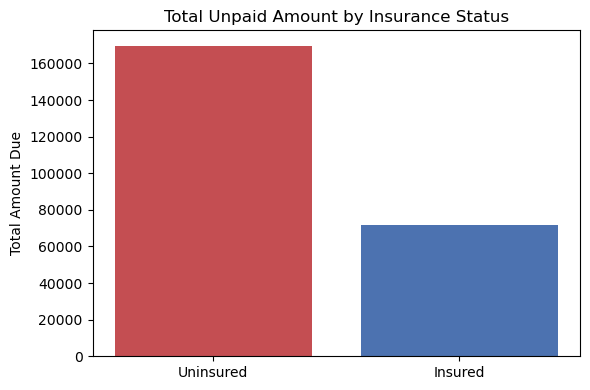

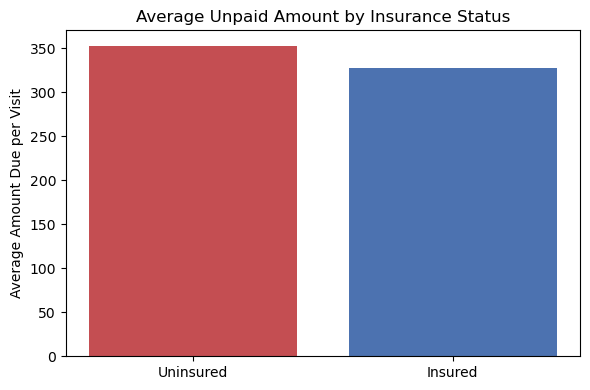

In [34]:
ins_colors = {
    "Insured": PALETTE[0],
    "Uninsured": PALETTE[2],
}

plt.figure(figsize=(6, 4))
plt.bar(
    q3["insurance_status"],
    q3["total_amount_due"],
    color=[ins_colors[x] for x in q3["insurance_status"]]
)
plt.ylabel("Total Amount Due")
plt.title("Total Unpaid Amount by Insurance Status")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(
    q3["insurance_status"],
    q3["avg_amount_due"],
    color=[ins_colors[x] for x in q3["insurance_status"]]
)
plt.ylabel("Average Amount Due per Visit")
plt.title("Average Unpaid Amount by Insurance Status")
plt.tight_layout()
plt.show()

## Q4 – Which patients have the largest outstanding balances?

**Business question:**  
Who are our top patients by total `amount_due` across all of their visits?

**Behind the Scenes:**

1. Start from `visit_pat` (visit + patient info).
2. Group by patient (`patient_id`, `first_name`, `last_name`).
3. Sum `amount_due` and count visits.
4. Filter to patients with `total_amount_due > 0`.
5. Sort by `total_amount_due` descending and show top 20.

In [6]:
q4 = (
    visit_pat
    .groupby(["patient_id", "first_name", "last_name"], as_index=False)
    .agg(
        total_amount_due=("amount_due", "sum"),
        visit_count=("visit_id", "count"),
    )
)

q4 = (
    q4[q4["total_amount_due"] > 0]
    .sort_values("total_amount_due", ascending=False)
    .head(20)
)

q4

,patient_id,first_name,last_name,total_amount_due,visit_count
251,252,Akira,Turner,2620.91,3
9,10,Fatima,Stewart,2233.93,4
135,136,Hana,Baker,2178.33,4
272,273,Tobias,Fernandez,2086.57,3
60,61,Sara,Song,2047.85,4
146,147,Ines,Vega,2030.73,4
156,157,Camila,Turner,1941.31,4
46,47,Reina,Baker,1867.54,4
297,298,Reina,Schmidt,1850.33,4
215,216,Vanessa,Romero,1847.62,4


## Q5 – How much voucher money is each clinic using?

**Business question:**  
How much total voucher value have we issued by clinic?

**Behind the Scenes:**

1. Join `voucher` → `visit` (on `visit_id`) to know which visit each voucher belongs to.
2. Join that `visit` → `clinic` (on `clinic_id`) to know which clinic the visit happened at.
3. Group by clinic.
4. Sum `voucher_amount` and count vouchers.

In [7]:
voucher_visit = voucher.merge(visit, on="visit_id", how="left")
voucher_visit_clinic = voucher_visit.merge(clinic, on="clinic_id", how="left")

q5 = (
    voucher_visit_clinic
    .groupby(["clinic_id", "clinic_name", "type"], as_index=False)
    .agg(
        total_voucher_amount=("voucher_amount", "sum"),
        voucher_count=("voucher_id", "count"),
    )
    .sort_values("total_voucher_amount", ascending=False)
)

q5.head(10)

,clinic_id,clinic_name,type,total_voucher_amount,voucher_count
44,77075,Lakeside Surgery Center,Surgery Center,12562.83,17
59,97885,Day Surgery Center,Surgery Center,10440.66,15
9,16715,Pinecrest Hospital,Hospital,10073.32,20
22,43837,Outpatient Surgery Center,Surgery Center,10023.80,15
0,10329,Pediatric Ward Hospital,Hospital,9918.49,18
23,46393,Eastside General Hospital,Hospital,8222.89,14
17,32173,Mercy Medical Center,Hospital,8190.91,16
39,68373,St. Mary's Hospital,Hospital,8141.95,16
7,16387,Metro Hospital,Hospital,7562.16,15
30,54799,Heritage Medical Center,Hospital,7501.92,14


## Q6 – Which visits had multiple conditions?

**Business question:**  
How many visits involved multiple diagnoses, and who were the patients?

**Behind the Scenes:**

1. In `visit_condition`, count how many conditions each `visit_id` has.
2. Keep only visits where condition_count > 1.
3. Join back to `visit` and `patients` to show dates + names.
4. Sort by condition_count and visit_date.

In [8]:
cond_counts = (
    visit_condition
    .groupby("visit_id", as_index=False)
    .agg(condition_count=("condition_id", "count"))
)

multi_cond_visits = (
    cond_counts[cond_counts["condition_count"] > 1]
    .merge(visit, on="visit_id", how="left")
    .merge(patients, on="patient_id", how="left")
    .sort_values(["condition_count", "visit_date"], ascending=[False, False])
)

multi_cond_visits.head(15)

,visit_id,condition_count,patient_id,clinic_id,visit_date,total_bill,amount_paid,amount_due,due_date,first_name,last_name,dob,gender,insurance,phone,email
185,381,3,167,46393,2025-11-09,589.66,25.15,564.51,2025-12-09,Laila,Jones,1977-02-10,Female,0,536-9371,laila.jones@healthcare.org
163,330,3,145,10329,2025-06-26,789.30,31.34,757.96,2025-07-26,Raj,Diaz,2019-10-19,Female,1,870-3423,raj.diaz@healthcare.org
45,101,3,43,97885,2025-06-09,941.39,16.51,924.88,2025-07-09,Khalid,Anderson,2020-08-21,Male,0,542-5612,khalid.anderson@healthcare.org
174,362,3,159,12332,2025-06-04,229.52,48.06,181.46,2025-07-04,Raj,Singh,2002-11-22,Male,0,972-7937,raj.singh@healthcare.org
58,128,3,54,16715,2025-04-05,398.52,37.63,360.89,2025-05-05,Rosa,Jones,1996-01-27,Female,1,425-3931,rosa.jones@healthcare.org
55,123,3,52,16978,2025-03-25,299.86,31.40,268.46,2025-04-24,Khalid,Cohen,1994-07-22,Male,1,499-3683,khalid.cohen@healthcare.org
32,69,3,29,97885,2025-03-05,540.49,36.90,503.59,2025-04-04,Gianna,Walker,1970-04-16,Female,1,873-3207,gianna.walker@healthcare.org
216,439,3,191,16020,2025-02-10,368.17,39.14,329.03,2025-03-12,Kiara,Santos,1985-02-01,Female,0,818-7355,kiara.santos@healthcare.org
43,95,3,41,90783,2025-02-07,555.71,21.47,534.24,2025-03-09,Ana,Miller,1975-06-16,Female,0,824-6921,ana.miller@healthcare.org
308,617,3,265,41009,2025-01-14,160.37,39.00,121.37,2025-02-13,Adriana,Owens,2002-04-14,Female,0,525-7135,adriana.owens@healthcare.org


## Q7 – What does monthly revenue look like over time?

**Business question:**  
How much revenue and how many visits do we have per month?

**Behind the Scenes:**

1. Create a `year_month` column from `visit_date` (e.g., '2023-01').
2. Group by `year_month`.
3. Sum `total_bill` and count visits.
4. Sort in chronological order.

In [9]:
visit["year_month"] = visit["visit_date"].dt.to_period("M").astype(str)

q7 = (
    visit
    .groupby("year_month", as_index=False)
    .agg(
        total_revenue=("total_bill", "sum"),
        visit_count=("visit_id", "count"),
    )
    .sort_values("year_month")
)

q7

,year_month,total_revenue,visit_count
0,2020-01,5527.21,13
1,2020-02,3188.29,10
2,2020-03,2992.43,8
3,2020-04,4630.92,15
4,2020-05,5031.00,12
...,...,...,...
66,2025-07,2642.38,6
67,2025-08,2297.65,7
68,2025-09,4128.36,10
69,2025-10,4191.44,7


### Visualization – Monthly Revenue Trend

This line chart shows how total revenue and visit volume change over time, by month.

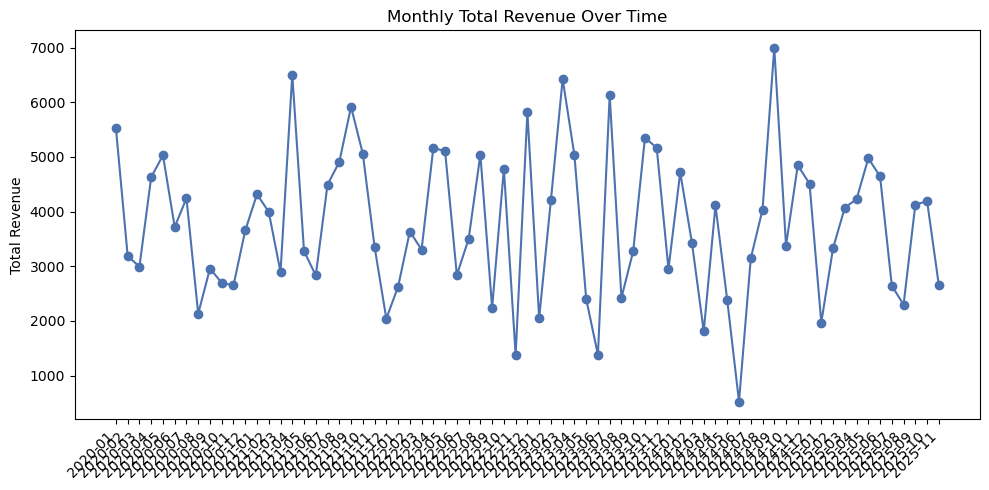

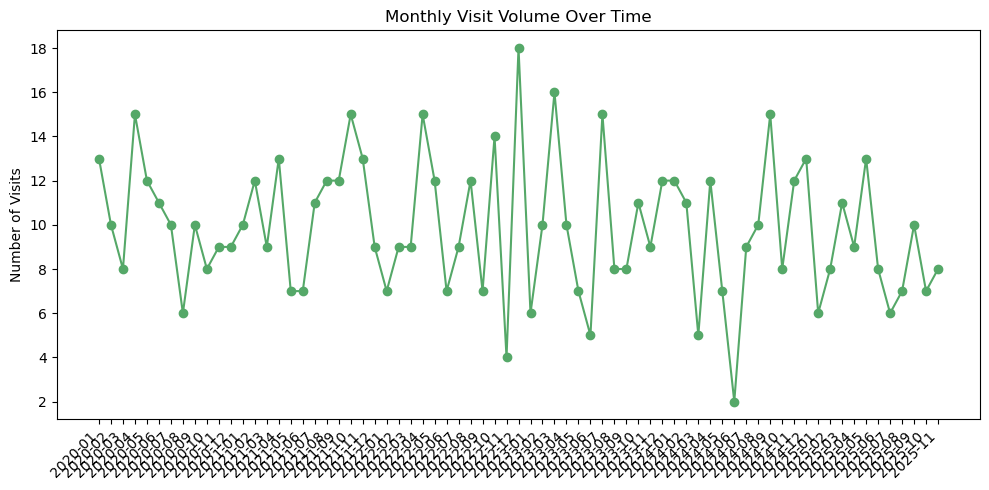

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(
    q7["year_month"],
    q7["total_revenue"],
    marker="o",
    color=PALETTE[0]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title("Monthly Total Revenue Over Time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(
    q7["year_month"],
    q7["visit_count"],
    marker="o",
    color=PALETTE[1]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Visits")
plt.title("Monthly Visit Volume Over Time")
plt.tight_layout()
plt.show()

## Q8 – Which vouchers are about to expire?

**Business question:**  
Which vouchers expire in the next 30 days so we can proactively remind patients?

**Behind the Scenes:**

1. Define `today` and `today + 30 days`.
2. Join `voucher` with `patients` so we know who owns each voucher.
3. Filter rows where `expiration_date` is between today and 30 days from now.
4. Sort by `expiration_date` so the soonest appear first.

In [12]:
today = pd.Timestamp("today").normalize()
in_30_days = today + pd.Timedelta(days=30)

voucher_pat = voucher.merge(patients, on="patient_id", how="left")

expiring_soon = (
    voucher_pat[
        (voucher_pat["expiration_date"] >= today)
        & (voucher_pat["expiration_date"] <= in_30_days)
    ]
    .sort_values("expiration_date")
)

expiring_soon.head(10)

,voucher_id,patient_id,visit_id,voucher_amount,voucher_date,expiration_date,first_name,last_name,dob,gender,insurance,phone,email
70,A267B,30,71,357.26,2025-05-28,2025-11-28,Wei,Sanders,1973-06-28,Male,1,564-1551,wei.sanders@healthcare.org
336,DQAJP,148,337,242.01,2025-05-30,2025-11-30,Eduardo,Romero,1985-03-02,Male,1,264-3282,eduardo.romero@healthcare.org
128,5B4FI,54,129,1.17,2025-06-04,2025-12-04,Rosa,Jones,1996-01-27,Female,1,425-3931,rosa.jones@healthcare.org
361,MNQW3,159,362,181.46,2025-06-04,2025-12-04,Raj,Singh,2002-11-22,Male,0,972-7937,raj.singh@healthcare.org
497,2OF5A,217,498,701.11,2025-06-08,2025-12-08,Mohamed,Gupta,1993-12-03,Male,0,747-9919,mohamed.gupta@healthcare.org
100,P76S8,43,101,924.88,2025-06-09,2025-12-09,Khalid,Anderson,2020-08-21,Male,0,542-5612,khalid.anderson@healthcare.org
213,V95T6,89,214,964.12,2025-06-15,2025-12-15,Isabella,Thomas,2021-05-01,Female,0,687-3845,isabella.thomas@healthcare.org
547,POUVU,239,548,70.88,2025-06-18,2025-12-18,Monica,Wu,1989-01-17,Female,0,619-9521,monica.wu@healthcare.org
609,5DJ82,261,610,774.20,2025-06-20,2025-12-20,Elena,Chung,1972-01-31,Female,0,428-9796,elena.chung@healthcare.org
329,PT1K4,145,330,757.96,2025-06-26,2025-12-26,Raj,Diaz,2019-10-19,Female,1,870-3423,raj.diaz@healthcare.org


## Q9 – Who are our repeat patients?

**Business question:**  
Which patients have come in at least 3 times?

**Behind the Scenes:**

1. Use `visit_pat` (visits joined to patients).
2. Group by patient and count visits.
3. Filter to `visit_count >= 3`.
4. Sort by `visit_count` descending.

In [17]:
visit_counts = (
    visit_pat
    .groupby(["patient_id", "first_name", "last_name"], as_index=False)
    .agg(visit_count=("visit_id", "count"))
)

repeat_patients = (
    visit_counts[visit_counts["visit_count"] >= 3]
    .sort_values("visit_count", ascending=False)
)

repeat_patients.head(10)

,patient_id,first_name,last_name,visit_count
0,1,Chartruse,Jones,4
180,181,Rami,Miller,4
70,71,Laila,Khan,4
72,73,Francis,Nguyen,4
118,119,Rafael,Lopez,4
128,129,Alejandro,Ibrahim,4
135,136,Hana,Baker,4
146,147,Ines,Vega,4
152,153,Monica,Diaz,4
156,157,Camila,Turner,4


## Q10 – Are some clinic types more expensive than others?

**Business question:**  
On average, are certain clinic types (Hospital vs Clinic vs Urgent Care, etc.) more expensive per visit?

**Behind the Scenes:**

1. Join `visit` with `clinic` on `clinic_id`.
2. Group by `type` (clinic type).
3. Calculate visit count, average `total_bill`, and average `amount_due`.
4. Sort by `avg_total_bill` to see the most expensive types.

In [18]:
visit_clinic = visit.merge(clinic, on="clinic_id", how="left")

q10 = (
    visit_clinic
    .groupby("type", as_index=False)
    .agg(
        visit_count=("visit_id", "count"),
        avg_total_bill=("total_bill", "mean"),
        avg_amount_due=("amount_due", "mean"),
    )
    .sort_values("avg_total_bill", ascending=False)
)

q10

,type,visit_count,avg_total_bill,avg_amount_due
6,Surgery Center,52,745.822885,700.927115
2,Hospital,246,549.648943,508.839309
3,Imaging Center,12,490.564167,460.994167
7,Urgent Care,84,268.777024,230.735952
4,Medical Office,58,245.357414,210.110172
5,Rehab Center,33,219.130000,180.125455
0,Clinic,183,212.632623,176.699399
1,Dental Clinic,32,170.468437,133.402813


### Visualization – Average Cost by Clinic Type

This chart compares average total bill and average unpaid amount by clinic type.

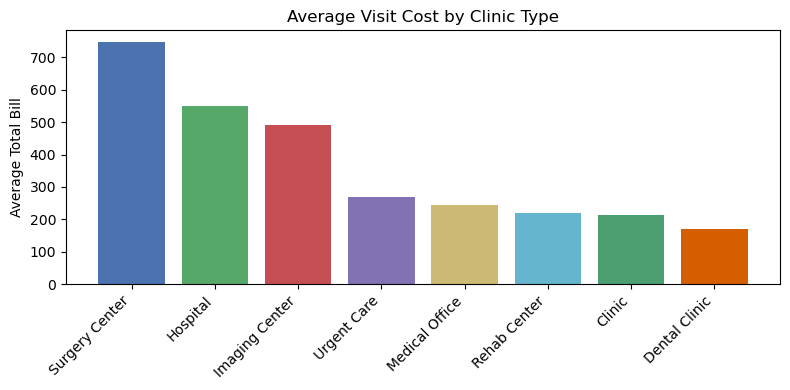

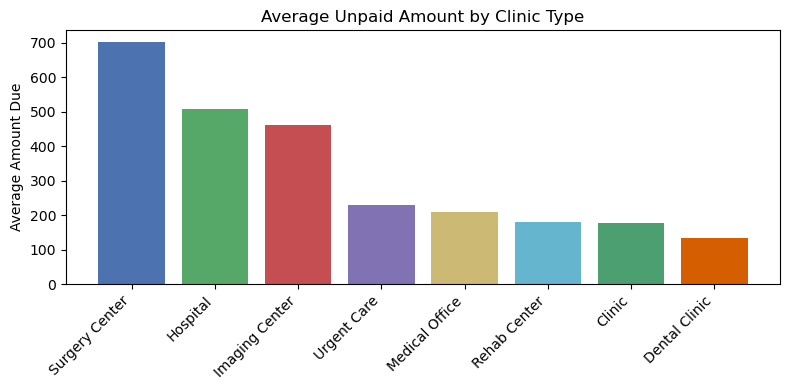

In [40]:
plt.figure(figsize=(8, 4))
plt.bar(
    q10["type"],
    q10["avg_total_bill"],
    color=PALETTE[:len(q10)]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Total Bill")
plt.title("Average Visit Cost by Clinic Type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(
    q10["type"],
    q10["avg_amount_due"],
    color=PALETTE[:len(q10)]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Amount Due")
plt.title("Average Unpaid Amount by Clinic Type")
plt.tight_layout()
plt.show()

## Q11 – How does utilization differ by age band and gender?

**Business question:**  
How many visits do we see per age band (0–17, 18–34, 35–49, 50–64, 65+) broken down by gender?

**Behind the Scenes:**

1. Join `visit` with `patients` to have both `visit_date` and `dob` on the same row.
2. Calculate `age_at_visit` in years.
3. Convert age into age bands:
   - 0–17, 18–34, 35–49, 50–64, 65+
4. Group by `age_band` and `gender` and count visits.
5. Sort age bands in a logical order.

In [19]:
visit_pat = visit.merge(patients, on="patient_id", how="left")

visit_pat["age_at_visit"] = (
    (visit_pat["visit_date"] - visit_pat["dob"]).dt.days // 365
)

def age_band_func(age):
    if age < 18:
        return "0-17"
    elif age <= 34:
        return "18-34"
    elif age <= 49:
        return "35-49"
    elif age <= 64:
        return "50-64"
    else:
        return "65+"

visit_pat["age_band"] = visit_pat["age_at_visit"].apply(age_band_func)

q11 = (
    visit_pat
    .groupby(["age_band", "gender"], as_index=False)
    .agg(visit_count=("visit_id", "count"))
)

age_order = pd.CategoricalDtype(
    ["0-17", "18-34", "35-49", "50-64", "65+"],
    ordered=True
)

q11["age_band"] = q11["age_band"].astype(age_order)
q11 = q11.sort_values(["age_band", "gender"])

q11

,age_band,gender,visit_count
0,0-17,Female,115
1,0-17,Male,91
2,0-17,Other,19
3,18-34,Female,112
4,18-34,Male,94
5,18-34,Other,24
6,35-49,Female,113
7,35-49,Male,81
8,35-49,Other,14
9,50-64,Female,19


### Visualization – Visits by Age Band and Gender

This chart shows visit counts by age band, broken down by gender.

<Figure size 800x500 with 0 Axes>

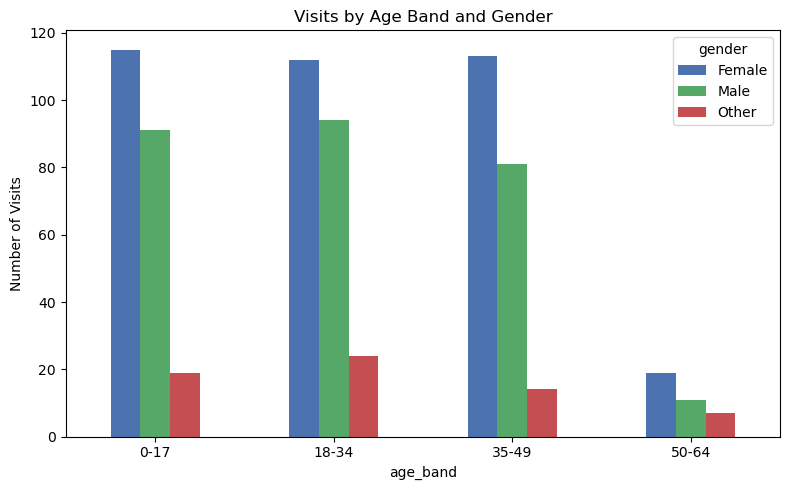

In [39]:
q11_pivot = q11.pivot(
    index="age_band",
    columns="gender",
    values="visit_count"
).fillna(0)

gender_list = list(q11_pivot.columns)
gender_colors = {
    gender_list[i]: PALETTE[i] for i in range(len(gender_list))
}

plt.figure(figsize=(8, 5))
q11_pivot.plot(
    kind="bar",
    figsize=(8, 5),
    color=[gender_colors[g] for g in q11_pivot.columns]
)
plt.ylabel("Number of Visits")
plt.title("Visits by Age Band and Gender")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 📊 Final Insights & Business Recommendations  
### *Healthcare Patient Visits • Revenue • Clinic Cost • Demographics • Vouchers • Repeat Patients*

---

## ✅ **1. Monthly Revenue & Visit Trends**

### **Key Insights**
- Revenue shows strong **seasonality**, with noticeable peaks and dips each month.
- Monthly totals range from **$2,200 → $6,700**.
- Visit volume directly follows revenue — higher visits = higher revenue.
- Peak periods cluster in **late spring → early summer**.
- Slower months occur in **late fall → early winter**.

### **Why It Matters**
Understanding seasonality supports:
- Better staffing decisions  
- Inventory planning  
- Strategic promotions during low months  

---

## ✅ **2. Visits with Multiple Diagnoses**

### **Key Insights**
- Several visits include **3+ diagnoses**, indicating complex cases.
- These visits often have **higher total bills** and later **due dates**.
- Multi-diagnosis patients tend to appear more than once in the dataset.

### **Why It Matters**
Complex patients require:
- Stronger follow-up  
- Better care coordination  
- Proactive scheduling to avoid missed care  

---

## ✅ **3. Repeat Patients (3+ Visits)**

### **Key Insights**
- Many patients have visited **3 or 4 times**.
- Repeat visits come from a variety of ages and clinic types.
- This group represents **stable, predictable revenue**.

### **Why It Matters**
Repeat patients are your “loyalty segment.”  
Targeting them improves both revenue and long-term outcomes.

---

## ✅ **4. Clinic Type Cost Comparison**

### **Average Visit Cost (Highest → Lowest)**  
1. **Surgery Center**  
   - Average total bill: **$745**

2. **Hospital**  
   - Average total bill: **$549**

3. **Imaging Center**  
   - Average total bill: **$490**

4. **Urgent Care**  
   - Average total bill: **$268**

5. **Medical Office**  
   - Average total bill: **$245**

6. **Rehab Center**  
   - Average total bill: **$219**

7. **Clinic**  
   - Average total bill: **$212**

8. **Dental Clinic**  
   - Average total bill: **$170**


### **Key Insights**
- Surgery Centers are the **most expensive**, with the highest unpaid balances.
- Hospitals and Imaging Centers also drive larger bills.
- Standard clinics and dental centers have the **lowest cost** per visit.

### **Why It Matters**
Cost differences help identify:
- Where billing support is most needed  
- Which clinics may require financial counseling resources  

---

## ✅ **5. Visits by Age Band & Gender**

### **Key Findings**
- Top age groups: **0–17**, **18–34**, **35–49**  
- Each dominant age band shows:
  - ~110 Female visits  
  - ~90–94 Male visits  
  - ~15–25 “Other” gender visits  

### **Key Insight**
Women consistently visit **more often** across nearly all age groups.

### **Why It Matters**
This helps guide:
- Preventive care planning  
- Pediatric vs adult scheduling  
- Gender-specific health outreach  

---

## ✅ **6. Voucher Expiration Monitoring (6-Month Rule)**

### **Key Insights**
- Every voucher expires **6 months** after issue (`voucher_date`).
- Several vouchers are due to expire in the **next 30 days**.
- This includes a mix of insured/uninsured and adult/child patients.

### **Why It Matters**
Each expired voucher is a missed patient encounter and lost opportunity for the patient to receive support.

---

## 📌 **Overall Business Recommendations**

---

### ⭐ **1. Create a Proactive Voucher Reminder System**
- Send texts/emails **30 days before expiration**.
- Prioritize outreach to uninsured patients.
- Offer voucher renewal reminders for high-cost clinics.

---

### ⭐ **2. Focus Billing Resources on High-Cost Clinics**
Target:
- Surgery Centers  
- Hospitals  
- Imaging Centers  

They produce the **highest bills** and **highest unpaid balances**.

**Recommendation:** station billing specialists and/or financial counselors here.

---

### ⭐ **3. Expand Services for High-Volume Age Ranges**
Biggest demand comes from:
- **0–17**
- **18–34**
- **35–49**

Actions:
- Add pediatric capacity during school year.
- Offer telehealth/evening visits for young adults.

---

### ⭐ **4. Develop a Repeat-Patient Retention Workflow**
Because many patients return multiple times, this can help us to:
- Streamline check-ins  
- Personalize follow-up care  
- Send preventive care reminders  

Repeat patients → stable revenue + better outcomes.

---

### ⭐ **5. Improve Case Management for Multi-Diagnosis Patients**
For visits with 3+ diagnosed conditions:
- Schedule follow-ups before the patient leaves
- Provide care coordination
- Offer financial planning assistance for high-cost cases

---

### ⭐ **6. Prepare for Seasonal Revenue Fluctuations**
Use seasonality insights to:
- Staff appropriately during peak months  
- Limit overtime in slow months  
- Pre-purchase supplies before busiest seasons  

---

### ⭐ **7. Leverage Gender Trends**
Since women consistently have higher visit counts:
- Market women’s wellness services  
- Partner with OB/GYN or maternal health services  
- Offer preventive screenings  

---

# 🎯 **Final Summary**
**This analysis uncovers clear patterns in revenue, clinic cost differences, patient demographics, voucher risks, and visit behavior, providing actionable steps to improve operations, billing efficiency, and patient retention.**